# Smooth Quant


In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
generation_length = 1024

print(f"Using device: {device}")

# --- Load Model and Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name)

# FIX: Revert to 8-bit loading to create a consistent, memory-bound bottleneck
# This requires the 'bitsandbytes' library (`pip install bitsandbytes`)
print("Loading model in 8-bit to maximize memory for the KV cache...")
model = AutoModelForCausalLM.from_pretrained(model_name, load_in_8bit=True)
model.config.use_cache = True

print("Setup complete.")

# --- VRAM Monitoring Helper Function ---
def get_vram_usage():
    if device == "cuda":
        # memory_allocated can sometimes be misleading, reserved gives a fuller picture
        return torch.cuda.memory_reserved(0) / (1024**3)
    return 0

Using device: cuda
Loading model in 8-bit to maximize memory for the KV cache...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Setup complete.


In [3]:
def analyze_inference_baseline(model, tokenizer):
    """
    Runs a true baseline test with a full FP16 KV cache.
    """
    print("\n--- Running test for strategy: 'TRUE BASELINE' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            
            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print("'TRUE BASELINE' test complete.")
    return timings, vram_usage

def analyze_inference_smoothquant(model, tokenizer):
    """
    Runs an inference test using a simplified SmoothQuant strategy with aggressive memory management.
    """
    print("\n--- Running test for strategy: 'SmoothQuant (INT8 Cache)' ---")
    
    quantization_scale = 200.0

    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values_quantized = None
    timings = []
    vram_usage = []

    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()

            past_key_values_fp16 = None
            if past_key_values_quantized is not None:
                # 1. De-quantize for model input
                past_key_values_fp16 = tuple(
                    (layer[0].to(torch.float16) / quantization_scale, layer[1].to(torch.float16) / quantization_scale)
                    for layer in past_key_values_quantized
                )
                # FIX: Immediately delete the old quantized cache to save memory
                del past_key_values_quantized

            # 2. Run the model
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values_fp16)
            
            # FIX: Immediately delete the temporary FP16 input cache
            if past_key_values_fp16 is not None:
                del past_key_values_fp16

            # 3. Quantize the new cache for storage
            pkv_fp16 = outputs.past_key_values
            past_key_values_quantized = tuple(
                ((layer[0] * quantization_scale).to(torch.int8), (layer[1] * quantization_scale).to(torch.int8))
                for layer in pkv_fp16
            )
            
            # FIX: Immediately delete the large FP16 output cache from the model
            del pkv_fp16
            del outputs
            torch.cuda.empty_cache() # Force PyTorch to release the freed memory

            next_token_id = torch.argmax(model(input_ids=input_ids[:, -1:]).logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            end_time = time.perf_counter()

            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
                
    print("'SmoothQuant' test complete.")
    return timings, vram_usage

In [4]:
# --- Run the Two Experiments ---
baseline_timings, baseline_vram = analyze_inference_baseline(model, tokenizer)
smoothquant_timings, smoothquant_vram = analyze_inference_smoothquant(model, tokenizer)



--- Running test for strategy: 'TRUE BASELINE' ---
Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'TRUE BASELINE' test complete.

--- Running test for strategy: 'SmoothQuant (INT8 Cache)' ---


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


Generated 100/1024 tokens...
Generated 200/1024 tokens...
Generated 300/1024 tokens...
Generated 400/1024 tokens...
Generated 500/1024 tokens...
Generated 600/1024 tokens...
Generated 700/1024 tokens...
Generated 800/1024 tokens...
Generated 900/1024 tokens...
Generated 1000/1024 tokens...
'SmoothQuant' test complete.


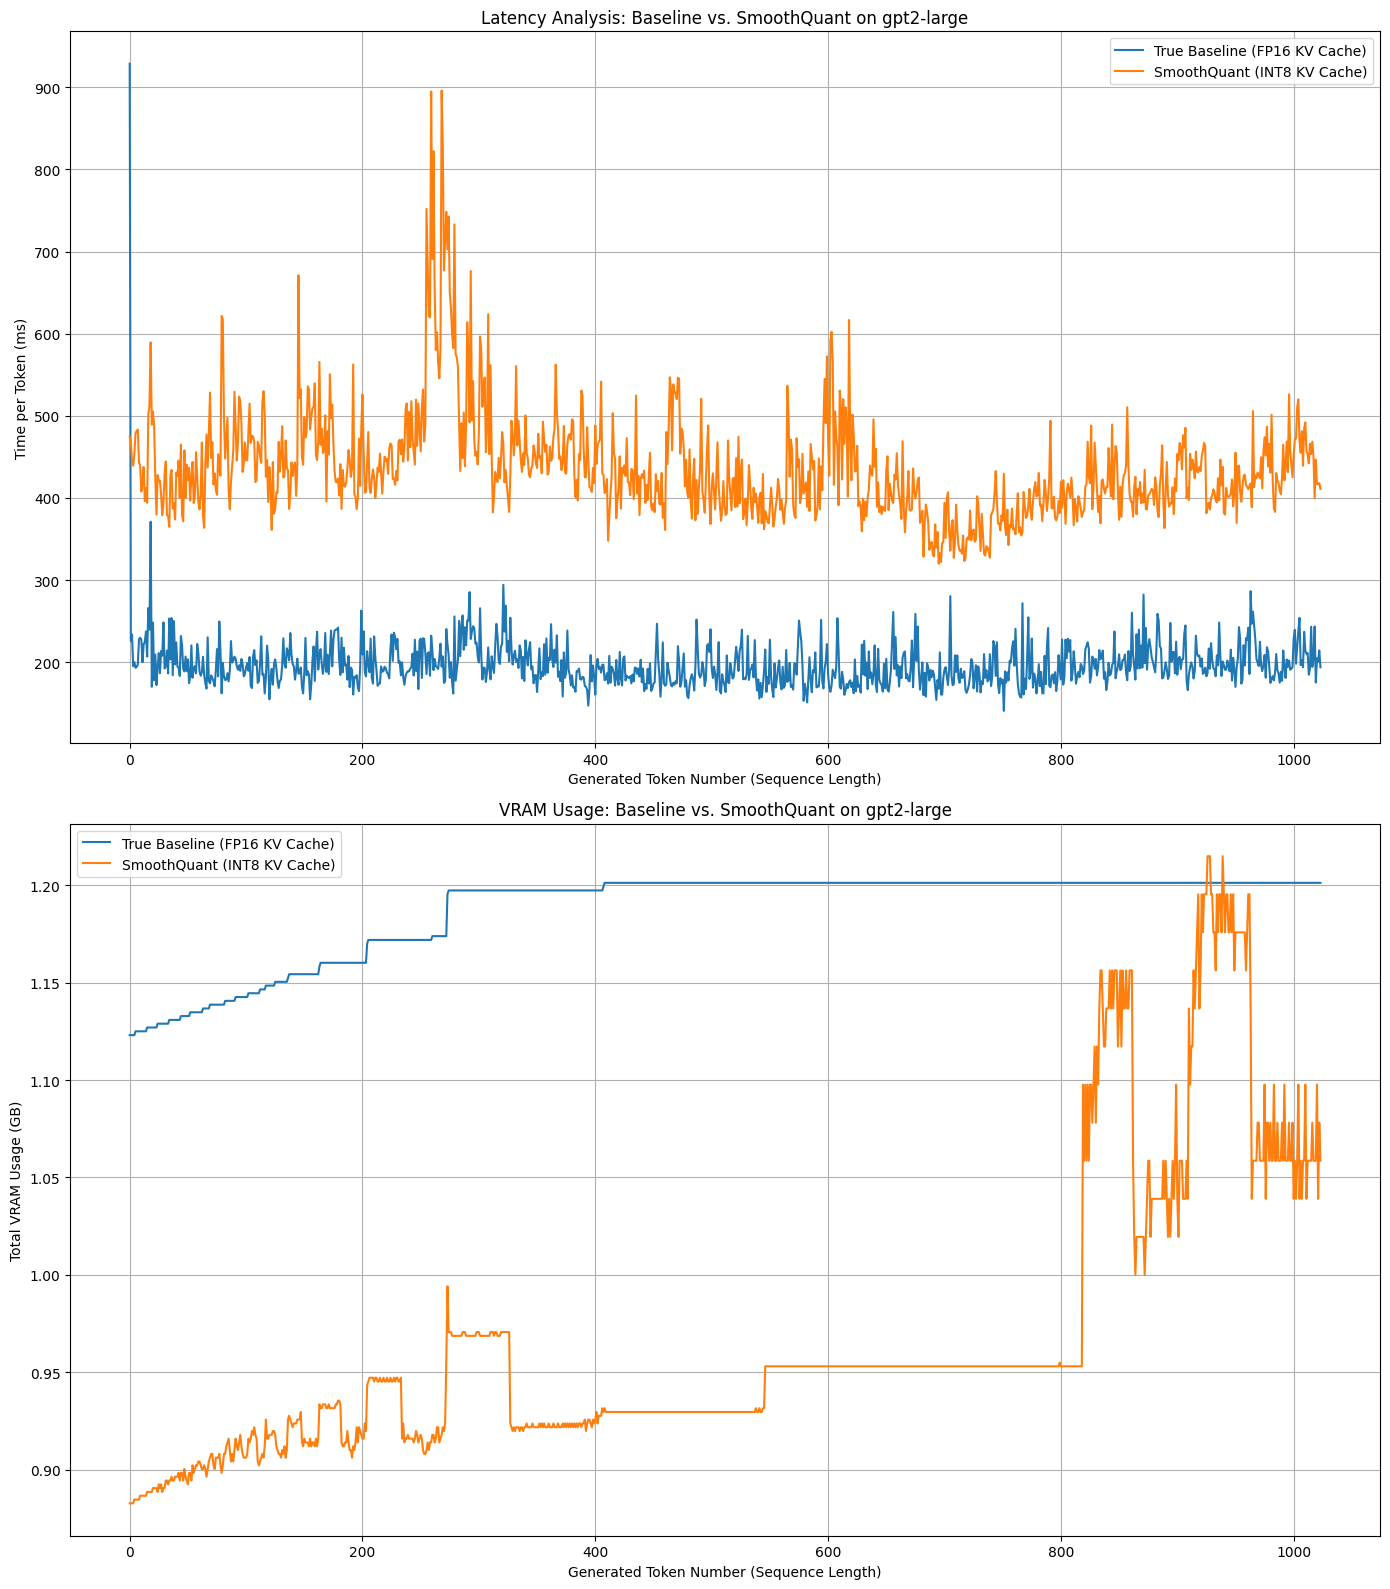

In [6]:
# --- Create the Plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot 1: Latency (Time per Token)
ax1.plot(baseline_timings, label='True Baseline (FP16 KV Cache)')
ax1.plot(smoothquant_timings, label='SmoothQuant (INT8 KV Cache)')
ax1.set_xlabel('Generated Token Number (Sequence Length)')
ax1.set_ylabel('Time per Token (ms)')
ax1.set_title(f'Latency Analysis: Baseline vs. SmoothQuant on {model_name}')
ax1.legend()
ax1.grid(True)

# Plot 2: VRAM Usage
ax2.plot(baseline_vram, label='True Baseline (FP16 KV Cache)')
ax2.plot(smoothquant_vram, label='SmoothQuant (INT8 KV Cache)')
ax2.set_xlabel('Generated Token Number (Sequence Length)')
ax2.set_ylabel('Total VRAM Usage (GB)')
ax2.set_title(f'VRAM Usage: Baseline vs. SmoothQuant on {model_name}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()